# Multi Layer (3 hidden, 1 output) Diagonal ReLU Recurrent Network (Pachitariu 2013) to sMNIST/rowMNIST
## This code uses flax.linen.scan to speed up the loop over time

## Equations
The recurrent weights are now diagonal matrices, which means we can do hadamard products instead of matrix multiplications. These weights are sampled uniformly between -0.999 and 0.999 to ensure that the eigenvalues are less than 1. 

The input and output weights are still dense matrices sampled using LeCun normal initialization.

All biases are initialized to zero.

Initialization:

$
W_{hx}^1 \in \mathbb{R}^{n_h \times n_x} \text{ with } W_{hx}^1 \text{ sampled } \sim \mathcal{N}(0, \sqrt{\frac{1}{n_x}}) \\
W_{hx}^2, W_{hx}^3 \in \mathbb{R}^{n_h \times n_h} \text{ with } W_{hx}^2, W_{hx}^3 \text{ sampled } \sim \mathcal{N}(0, \sqrt{\frac{1}{n_h}}) \\
\vec{w}_{hh}^1, \vec{w}_{hh}^2, \vec{w}_{hh}^3\in \mathbb{R}^{n_h} \text{ with } \vec{w}_{hh}^1, \vec{w}_{hh}^2, \vec{w}_{hh}^3 \text{ sampled } \sim \mathcal{U}(0.999, -0.999) \\
\vec{b}_h^1, \vec{b}_h^2, \vec{b}_h^3 \in \mathbb{R}^{n_h} \\
W_{hy} \in \mathbb{R}^{n_y \times n_h} \text{ with } W_{hy} \text{ sampled } \sim \mathcal{N}(0, \sqrt{\frac{1}{n_h}}) \\
\vec{b}_o \in \mathbb{R}^{n_y} \\
$


State update:

$
\vec{h}_t^1 = \text{ReLU}(W_{hx}^1\vec{x}_t + \vec{w}_{hh}^1\odot\vec{h}_{t-1}^1 + \vec{b}_h^1) \text{ with }\vec{h}_t^1 \in \mathbb{R}^{n_h} \text{ and } \vec{x}_t \in \mathbb{R}^{n_x} \\
\vec{h}_t^2 = \text{ReLU}(W_{hx}^2\vec{h}_t^1 + \vec{w}_{hh}^2\odot\vec{h}_{t-1}^2 + \vec{b}_h^2) \text{ with }\vec{h}_t^2 \in \mathbb{R}^{n_h} \\
\vec{h}_t^3 = \text{ReLU}(W_{hx}^3\vec{h}_t^2 + \vec{w}_{hh}^3\odot\vec{h}_{t-1}^2 + \vec{b}_h^3) \text{ with }\vec{h}_t^3 \in \mathbb{R}^{n_h} \\
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W_{hy}\vec{h}_t^3 + \vec{b}_o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

<font color='green'>THINGS SOLVED</font>
- exploding activations --> change the recurrent weight initialization to ensure |w| < 1 

<font color='red'>THINGS TO UNDERSTAND</font>
- why init in glorot using (256,) does not work? --> my own init function
- understand why getting the params in the layers doesn't work
- understand why not running on GPU


In [1]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/home/tristan/LearningJAX/Flax
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25+cuda11.cudnn86
optax==0.1.8
orbax-checkpoint==0.5.0


In [2]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from flax.training import train_state
import optax
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']

jnp.set_printoptions(precision=3, suppress=True)

# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from utils import create_mnist_classification_dataset, plot_dynamics

In [28]:
DATASET_VERSION = "sequential"
trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data", version=DATASET_VERSION)

[*] Generating MNIST Classification Dataset...


In [29]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

(128, 784, 1) (128,)
int64


In [30]:
from typing import Sequence

def rec_initializer():
    def init(key, shape):
        return jax.random.uniform(key, shape, minval=-0.999, maxval=0.999)
    return init

class IRRNCell(nn.Module):
    # hidden_size: int
    # out_size: int

    def setup(self):
        # self.Linear_in = nn.Dense(self.hidden_size, name='Whx')
        self.Linear_in = nn.Dense(256, name='Whx')
        # self.wh = self.param('wh', lecun_normal(), (self.hidden_size,))
        self.wh = self.param('wh', rec_initializer(), (2,256))
        self.wh = self.wh[0]
        # self.Linear_out = nn.Dense(self.out_size, name='Woh')
        self.Linear_out = nn.Dense(10, name='Woh')


    def __call__(self, state, x):
        # Wh @ h + Wx @ x + b can be efficiently computed
        # by concatenating the vectors and then having a single dense layer
        xb = self.Linear_in(x)
        decayed_state = self.wh * state
        new_state = jax.nn.relu(xb + decayed_state)
        out = self.Linear_out(new_state)
        return new_state, (new_state, out)
    
class SimpleScan(nn.Module):
    # hidden_size: int
    # out_size: int

    @nn.compact
    def __call__(self, state, x):
        IRRN = nn.scan(
            IRRNCell,
            variable_broadcast='params',
            split_rngs={'params': False},
            in_axes=0,
            out_axes=0,
        )
        return IRRN()(state, x)
    
class RNNLayer(nn.Module):
    hidden_size: int
    out_size: int

    def setup(self):
        self.SimpleScan = SimpleScan()


    def __call__(self, x):
        state = jnp.zeros((self.hidden_size,))
        
        _, (state_hist, out_hist) = self.SimpleScan(state, x)
        return state_hist, out_hist

class RNN(nn.Module):
    hidden_size: int
    output_size: int
    n_layers: int

    def setup(self):
        self.rnn_cells = [RNNLayer(self.hidden_size, self.output_size) for _ in range(self.n_layers)]
    def __call__(self, x):
        # print(x.shape)
        all_state_hist = []
        for id_layer, rnn_cell in enumerate(self.rnn_cells[:-1]):
            x, _ = rnn_cell(x)
            all_state_hist.append(x)
        state_hist, out_hist = self.rnn_cells[-1](x)
        all_state_hist.append(state_hist)
        return all_state_hist, out_hist
    
BatchRNN = nn.vmap(RNN, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})


In [31]:
srn = BatchRNN(256, 10, 3)
params = srn.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:5]))
all_state_hist, out_hist = srn.apply(params, batch_x[:5])
print(len(all_state_hist), all_state_hist[0].shape, all_state_hist[1].shape, all_state_hist[2].shape, out_hist.shape) # (batch, time, cell_size)
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

3 (5, 784, 256) (5, 784, 256) (5, 784, 256) (5, 784, 10)
(5, 10)
[[ 58.288  43.07   62.951 -70.338 -57.075  99.193  22.717  -5.076  29.665
  190.584]
 [ 50.368  35.972  53.092 -61.275 -48.17   85.374  19.066  -1.78   25.017
  164.297]
 [ 64.485  48.118  70.74  -77.237 -63.855 110.043  25.791  -7.893  32.993
  210.24 ]
 [ 42.915  28.987  42.628 -53.528 -38.716  72.125  14.821   3.453  20.174
  139.634]
 [ 57.17   41.913  61.706 -68.819 -55.904  97.263  22.358  -5.169  28.814
  186.312]]


In [32]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())


(5,)
[195.66  111.206 162.122  96.719 242.216]
161.58452


In [33]:
# print(params['params'].keys())
# print(params['params']['RNNLayer_0'].keys())
# print(params['params']['RNNLayer_0']['ScanRNNCell_0'].keys())

print('\nparams: \n', jax.tree_util.tree_map(jnp.shape, params['params']))

# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_Out']['kernel'].shape == (256, 10)
# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_Out']['bias'].shape == (10,)
# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['kernel'].shape == (257, 256)
# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['bias'].shape == (256,)


params: 
 {'rnn_cells_0': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (1, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}, 'rnn_cells_1': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}, 'rnn_cells_2': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}}


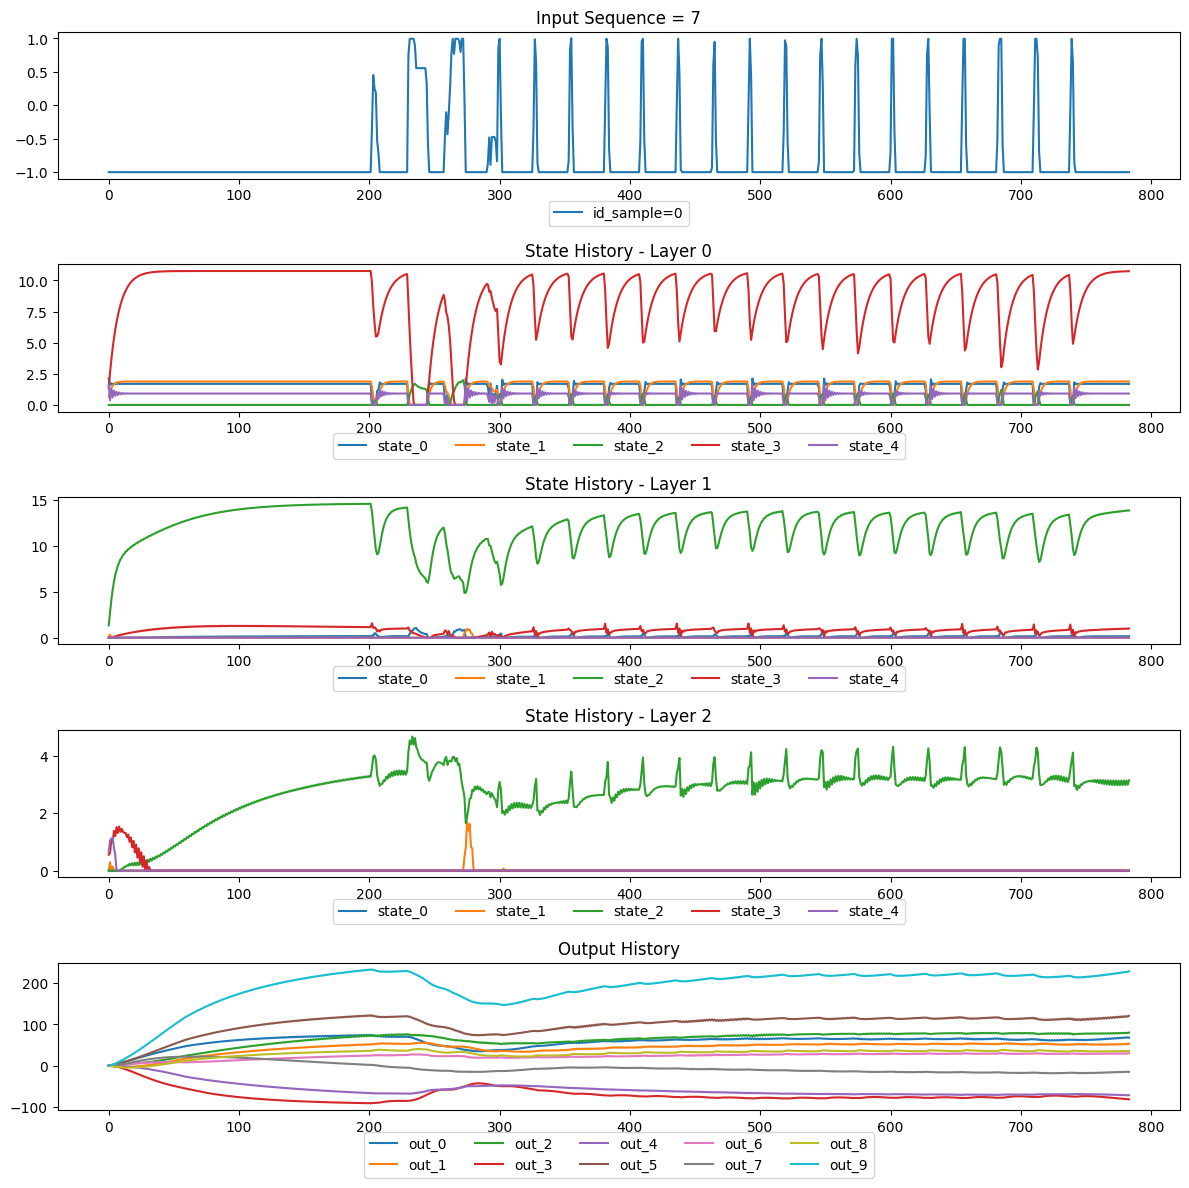

In [34]:
plot_dynamics(srn, params, batch_x, batch_y, DATASET_VERSION, id_sample=0, nb_inputs_to_plot=5, nb_components_to_plot=5)

In [35]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
lr = 1e-3

In [36]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [37]:
def apply_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy
    

In [38]:
def run_epoch(state, train_dl, rng):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []

    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    batch_id = 0
    for batch_images, batch_labels in progress_bar:
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        # print(jnp.max(grads['dense_0']['kernel']), jnp.min(grads['dense_0']['kernel']))
        # print(loss)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        batch_id += 1
        if batch_id % 3 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


In [39]:
def create_train_state(key, model_cls, lr, dataset_version):
    
    init_x = jnp.ones((128, 784, 1)) if dataset_version == "sequential" else jnp.ones((128, 28, 28))

    model = model_cls(hidden_size=256, output_size=10, n_layers=3)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure
    print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))

    optimizer = optax.adam(lr)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )


In [40]:
state = create_train_state(key, BatchRNN, lr, DATASET_VERSION)

Initialized parameter structure: {'rnn_cells_0': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (1, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}, 'rnn_cells_1': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}, 'rnn_cells_2': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}}


In [41]:
jax.devices()

[cuda(id=0)]

We can see that 1 epoch takes ~2min with this scan version.
The vanilla version takes ~2min for 10 batches --> 92 min / epoch.

In [44]:
for epoch in range(2):
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    print(f"Epoch {epoch} | Loss: {train_loss} | Accuracy: {train_accuracy}")

Training: 100%|██████████| 468/468 [09:32<00:00,  1.22s/it, accuracy=0.82, loss=0.637] 


Epoch 0 | Loss: 0.749786913394928 | Accuracy: 0.7476963400840759


Training: 100%|██████████| 468/468 [09:21<00:00,  1.20s/it, accuracy=0.711, loss=0.882]

Epoch 1 | Loss: 0.631913423538208 | Accuracy: 0.7879440188407898


In [23]:
print(jax.tree_util.tree_map(jnp.shape, params['params']))
print(jax.tree_util.tree_map(jnp.shape, state.params))

{'rnn_cells_0': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (28, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}, 'rnn_cells_1': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}, 'rnn_cells_2': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}}
{'rnn_cells_0': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (28, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}, 'rnn_cells_1': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}, 'rnn_cells_2': {'SimpleScan': {'ScanIRRNCell_0': {'Whx': {'bias': (256,), 'kernel': (256, 256)}, 'Woh': {'bias': (10,), 'kernel': (256, 10)}, 'wh': (2, 256)}}}}


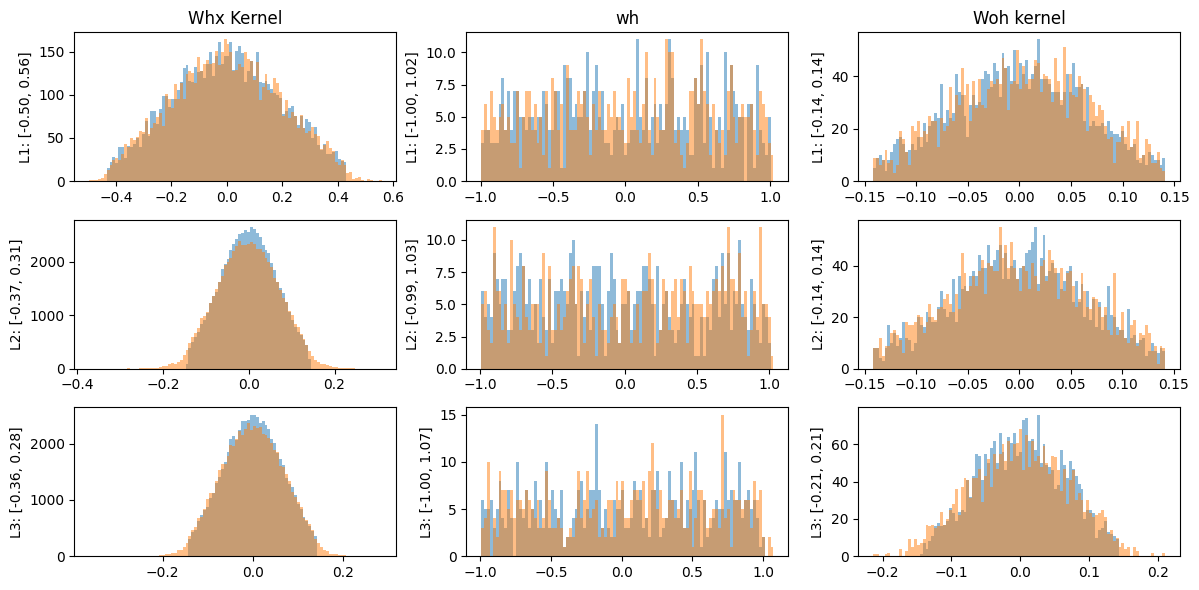

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(1200*px, 600*px))
axs[0,0].set_title('Whx Kernel')
axs[0,1].set_title('wh')
axs[0,2].set_title('Woh kernel')
for l in range(3):
    min_whx_init = params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Whx']['kernel'].min()
    min_whx = state.params[f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Whx']['kernel'].min()
    min_whx = min(min_whx_init, min_whx)

    min_wh_init = params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['wh'].min()
    min_wh = state.params[f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['wh'].min()
    min_wh = min(min_wh_init, min_wh)

    min_woh_init = params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Woh']['kernel'].min()
    min_woh = state.params[f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Woh']['kernel'].min()
    min_woh = min(min_woh_init, min_woh)

    max_whx_init = params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Whx']['kernel'].max()
    max_whx = state.params[f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Whx']['kernel'].max()
    max_whx = max(max_whx_init, max_whx)

    max_wh_init = params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['wh'].max()
    max_wh = state.params[f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['wh'].max()
    max_wh = max(max_wh_init, max_wh)

    max_woh_init = params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Woh']['kernel'].max()
    max_woh = state.params[f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Woh']['kernel'].max()
    max_woh = max(max_woh_init, max_woh)



    axs[l,0].hist(params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Whx']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_whx, max_whx))
    axs[l,1].hist(params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['wh'].flatten(), bins=100, alpha=0.5, range=(min_wh, max_wh))
    axs[l,2].hist(params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Woh']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_woh, max_woh))
    axs[l,0].hist(state.params[f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Whx']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_whx, max_whx))
    axs[l,1].hist(state.params[f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['wh'].flatten(), bins=100, alpha=0.5, range=(min_wh, max_wh))
    axs[l,2].hist(state.params[f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['Woh']['kernel'].flatten(), bins=100, alpha=0.5, range=(min_woh, max_woh))

    # y axis title
    axs[l,0].set_ylabel(f'L{l+1}: [{min_whx:.2f}, {max_whx:.2f}]')
    axs[l,1].set_ylabel(f'L{l+1}: [{min_wh:.2f}, {max_wh:.2f}]')
    axs[l,2].set_ylabel(f'L{l+1}: [{min_woh:.2f}, {max_woh:.2f}]')
    # set y range
plt.tight_layout()
plt.show()

In [25]:
jnp.min(params['params'][f'rnn_cells_{l}']['SimpleScan']['ScanIRRNCell_0']['wh'])

Array(-0.996, dtype=float32)

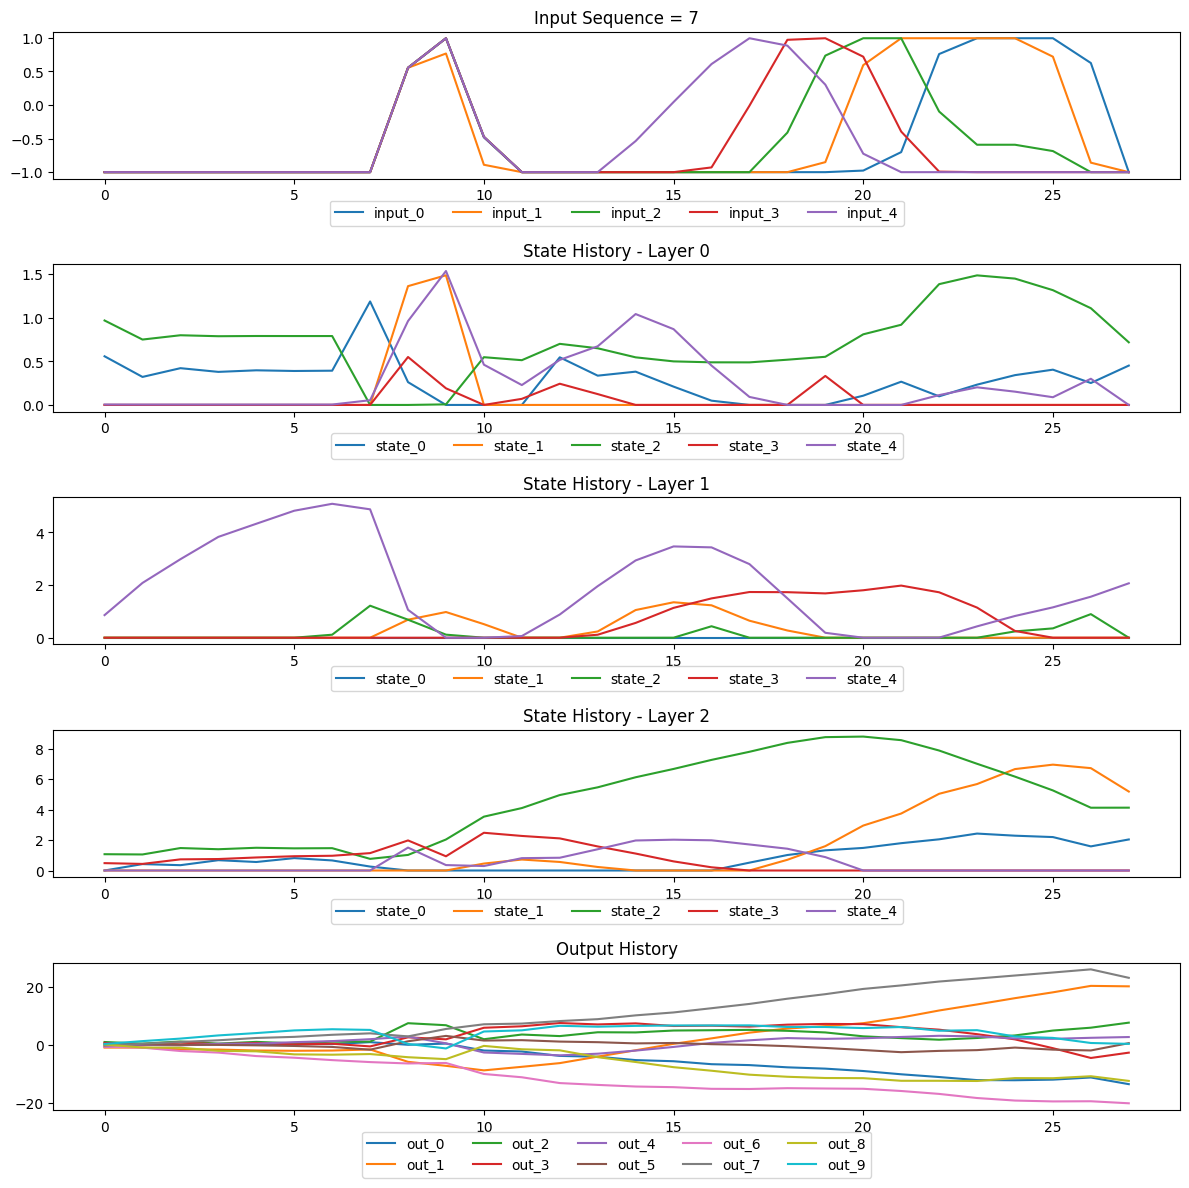

In [26]:
plot_dynamics(srn, state.params, batch_x, batch_y, DATASET_VERSION, id_sample=0, nb_inputs_to_plot=5, nb_components_to_plot=5)

In [27]:
all_state_hist, out_hist = srn.apply({'params':state.params}, batch_x[:5])
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())

(5, 10)
[[ -5.036   2.918   3.328   3.221   0.694  -0.184 -11.396  11.341  -6.513
    4.097]
 [ -2.019   2.191   8.772   0.646  -2.63    0.898   0.046  -2.489  -2.488
   -3.165]
 [ -3.176   8.932   1.83   -1.356   0.774  -1.378  -0.803   3.247  -4.477
   -1.182]
 [  3.983  -3.763   2.048  -1.874  -3.625  -2.047  -0.284  -5.523  -1.817
   -1.756]
 [ -0.162   2.278  -1.811 -10.196  12.529  -6.307  -1.707   6.346  -8.541
    5.345]]
(5,)
[0.002 0.002 0.005 0.158 0.003]
0.033834305
